In [10]:
import os
import sys
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.firewall_helper import ensure_firewall_access

### Connect and Load Data

In [ ]:
load_dotenv()

ensure_firewall_access()

engine = create_engine(os.getenv("AZ_SQL_CONNECTION_STRING"))
df = pd. read_sql("SELECT * FROM transit_delay_weather", engine)

print(df.shape)

(114658, 13)


In [6]:
df.head()

,date,route,time_x,day,location,incident,min_delay,min gap,direction,vehicle,time_y,temperature_2m (°c),precipitation (mm)
0,2023-01-01,91,02:30,Sunday,WOODBINE AND MORTIMER,Diversion,81,111,None,8772,2023-01-01,2.3,0.0
1,2023-01-01,69,02:34,Sunday,WARDEN STATION,Security,22,44,S,8407,2023-01-01,2.3,0.0
2,2023-01-01,35,03:06,Sunday,JANE STATION,Cleaning - Unsanitary,30,60,N,1051,2023-01-01,2.3,0.0
3,2023-01-01,900,03:14,Sunday,KIPLING STATION,Security,17,17,None,3334,2023-01-01,2.3,0.0
4,2023-01-01,85,03:43,Sunday,MEADOWALE LOOP,Security,1,1,None,1559,2023-01-01,2.3,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114658 entries, 0 to 114657
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 114658 non-null  object 
 1   route                114658 non-null  object 
 2   time_x               114658 non-null  object 
 3   day                  114658 non-null  object 
 4   location             114658 non-null  object 
 5   incident             114658 non-null  object 
 6   min_delay            114658 non-null  int64  
 7   min gap              114658 non-null  int64  
 8   direction            96532 non-null   object 
 9   vehicle              114658 non-null  int64  
 10  time_y               114658 non-null  object 
 11  temperature_2m (°c)  114658 non-null  float64
 12  precipitation (mm)   114658 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 11.4+ MB


In [8]:
df.describe(include='all')

,date,route,time_x,day,location,incident,min_delay,min gap,direction,vehicle,time_y,temperature_2m (°c),precipitation (mm)
count,114658,114658,114658,114658,114658,114658,114658.000000,114658.000000,96532,114658.000000,114658,114658.000000,114658.000000
unique,731,310,1440,7,17147,13,NaN,NaN,19,NaN,731,NaN,NaN
top,2023-01-25,32,16:00,Friday,KENNEDY STATION,Mechanical,NaN,NaN,N,NaN,2023-01-25,NaN,NaN
freq,322,3706,265,18431,3013,39040,NaN,NaN,26587,NaN,322,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,20.921261,33.559760,NaN,5752.698346,NaN,8.490217,0.127542
std,NaN,NaN,NaN,NaN,NaN,NaN,52.276810,54.453504,NaN,3679.308994,NaN,8.683683,0.618821
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,-25.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,16.000000,NaN,3234.000000,NaN,1.100000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,22.000000,NaN,7240.000000,NaN,8.900000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,40.000000,NaN,8566.000000,NaN,16.300000,0.000000


In [9]:
df.isna().sum().sort_values(ascending=False)

direction              18126
date                       0
route                      0
time_x                     0
day                        0
location                   0
incident                   0
min_delay                  0
min gap                    0
vehicle                    0
time_y                     0
temperature_2m (°c)        0
precipitation (mm)         0
dtype: int64

## Data Cleaning

In [16]:
# Renaming the Column Names
df.rename(columns={
    "time_x":"delay_time",
    "time_y":"weather_time",
    "min gap":"min_gap",
    "temperature_2m (°c)":"temperature",
    "precipitation (mm)":"precipitation",
    "day":"dayofweek"
}, inplace=True)


In [ ]:
# handling the missing values
df['direction'] = df['direction'].fillna("Unknown")

In [13]:
# Converting the data types
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['delay_time'] = pd.to_datetime(df['delay_time'], errors='coerce', format='%H:%M')
df['weather_time'] = pd.to_datetime(df['weather_time'], errors='coerce')


#Categorical data types
cat_cols = ['route','day', 'location', 'incident', 'direction']
for col in cat_cols:
    df[col] = df[col].astype('category')

df['vehicle'] = df['vehicle'].astype(str)

#Numerical data types
df['min_delay'] = pd.to_numeric(df['min_delay'], errors='coerce')
df['min_gap'] = pd.to_numeric(df['min_gap'], errors='coerce')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['precipitation'] = pd.to_numeric(df['precipitation'], errors='coerce')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113773 entries, 0 to 114657
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           113773 non-null  datetime64[ns]
 1   route          113773 non-null  category      
 2   delay_time     113773 non-null  datetime64[ns]
 3   dayofweek      113773 non-null  category      
 4   location       113773 non-null  category      
 5   incident       113773 non-null  category      
 6   min_delay      113773 non-null  int64         
 7   min_gap        113773 non-null  int64         
 8   direction      113773 non-null  category      
 9   vehicle        113773 non-null  object        
 10  weather_time   113773 non-null  datetime64[ns]
 11  temperature    113773 non-null  float64       
 12  precipitation  113773 non-null  float64       
dtypes: category(5), datetime64[ns](3), float64(2), int64(2), object(1)
memory usage: 9.2+ MB


In [15]:
#Removing extremities
df = df[df['min_delay'] < 300]

In [18]:
df['hour'] = pd.to_datetime(df['delay_time'], errors='coerce').dt.hour
df['month'] = pd.to_datetime(df['date'], errors='coerce').dt.month


## Visual Insights

### Average Delay per Hour

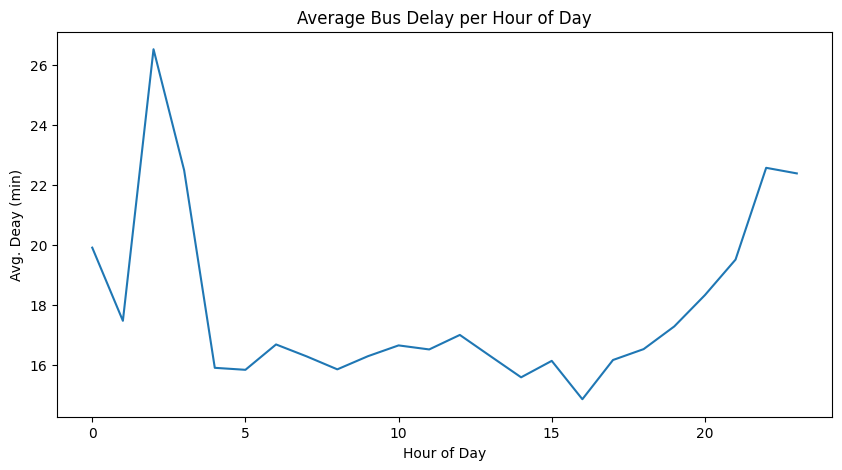

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='hour', y='min_delay', estimator='mean', errorbar=None)
plt.title("Average Bus Delay per Hour of Day")
plt.xlabel('Hour of Day')
plt.ylabel("Avg. Deay (min)")
plt.show()

### Average delay By Day of the Week

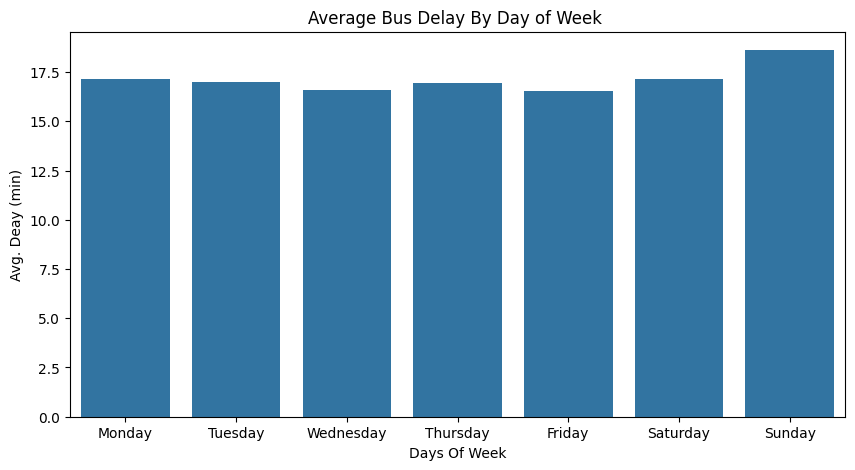

In [24]:
plt.figure(figsize=(10,5))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(data=df, x='dayofweek', y='min_delay', order=order, estimator='mean', errorbar=None)
plt.title("Average Bus Delay By Day of Week ")
plt.xlabel('Days Of Week')
plt.ylabel("Avg. Deay (min)")
plt.show()

### Top 10 Routes with Most Delays

/var/folders/5p/crkb3k995bqbqfflgj7hwz3w0000gn/T/ipykernel_31245/4207145596.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_routes = (df.groupby(['route'])['min_delay']


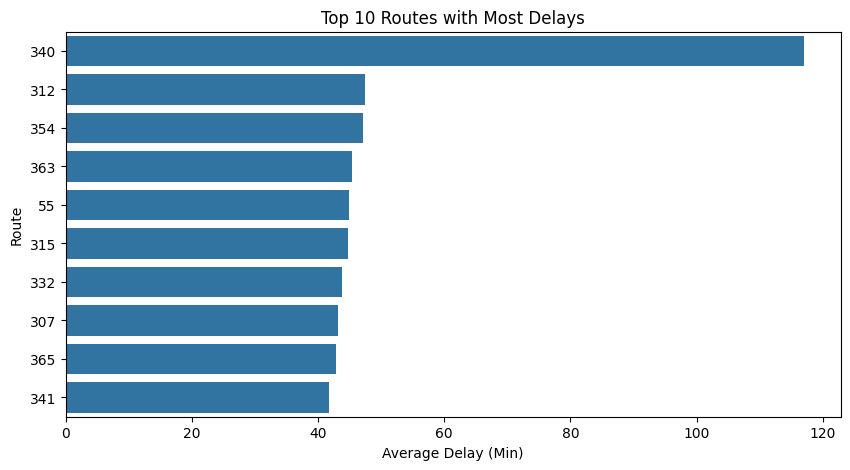

In [48]:
top_routes = (df.groupby(['route'])['min_delay']
              .mean()
              .reset_index()
              .sort_values(by='min_delay', ascending=False)
              .head(10))


plt.figure(figsize=(10,5))
sns.barplot(data=top_routes, x ='min_delay', y='route', order=top_routes['route'])
plt.title('Top 10 Routes with Most Delays')
plt.xlabel('Average Delay (Min)')
plt.ylabel('Route')
plt.show()

### Weather Impact

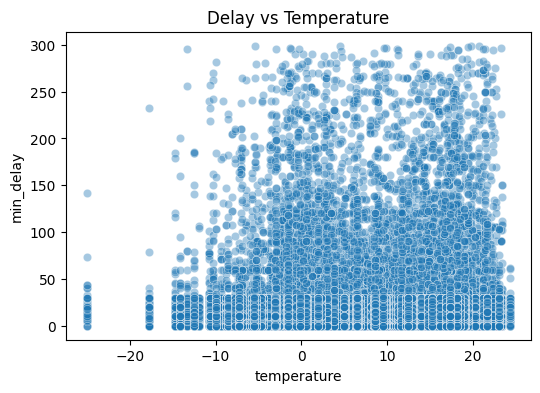

In [57]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='temperature', y='min_delay', alpha=0.4)
plt.title("Delay vs Temperature")
plt.show()


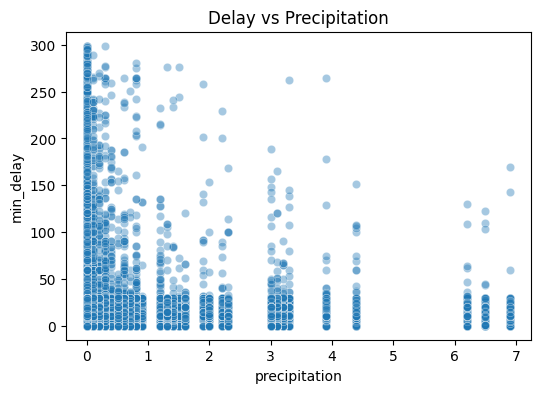

In [50]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='precipitation', y='min_delay', alpha=0.4)
plt.title("Delay vs Precipitation")
plt.show()


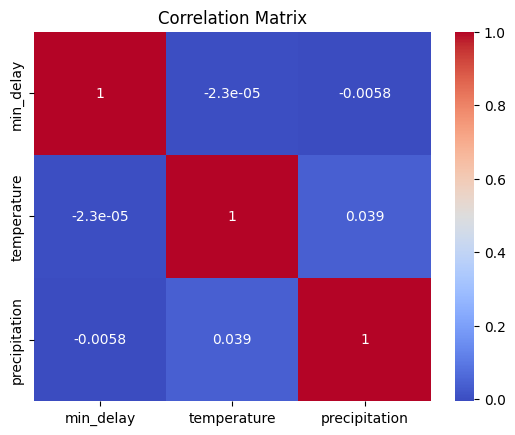

In [51]:
sns.heatmap(df[['min_delay','temperature','precipitation']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Incident Type Insights

/var/folders/5p/crkb3k995bqbqfflgj7hwz3w0000gn/T/ipykernel_31245/3634105159.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incident_delay = df.groupby("incident")["min_delay"].mean().reset_index().sort_values(by="min_delay",ascending=False).head(10)


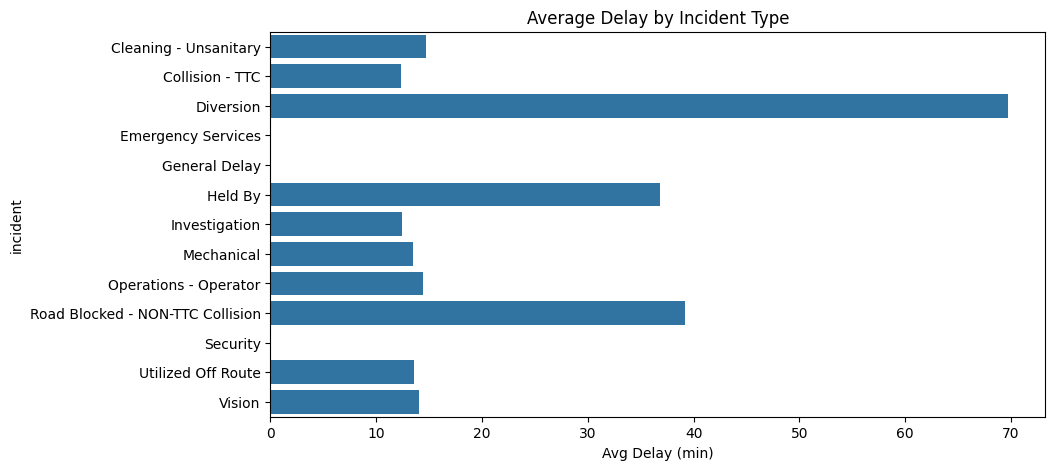

In [ ]:
incident_delay = df.groupby("incident")["min_delay"].mean().reset_index().sort_values(by="min_delay",ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(data= incident_delay,x='min_delay', y='incident')
plt.title("Average Delay by Incident Type")
plt.xlabel("Avg Delay (min)")
plt.ylabel("Incident")
plt.show()